In [1]:
import multiprocessing as mp
from multiprocessing import Pool, cpu_count

import numpy as np 
from scipy.special import gammaincinv, gamma, factorial, lambertw

from astropy.modeling import models 
from astropy.table import Table, vstack
from astropy.modeling import models, fitting
from astropy.modeling import custom_model, powerlaws, functional_models
from astropy.utils.console import ProgressBar
from astropy.convolution import convolve

from petrofit.models import sersic_enclosed, sersic_enclosed_inv, petrosian_profile, sersic_enclosed, make_grid, PSFModel
from petrofit.petrosian import Petrosian, PetrosianCorrection, calculate_petrosian,discrete_petrosian_r
from petrofit.fitting import model_to_image, fit_model
from petrofit.photometry import calculate_photometic_density,  make_radius_list
from petrofit.petrosian import Petrosian
from petrofit.utils import closest_value_index, get_interpolated_values
from scipy.interpolate import interp1d
from petrofit.petrosian import fraction_flux_to_r

%matplotlib inline

from matplotlib import pyplot as plt

plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['image.origin'] = 'lower'
#plt.rcParams.update({'font.size': 17})


import matplotlib.pyplot as plt

SMALL_SIZE = 12
MEDIUM_SIZE = 15
BIGGER_SIZE = 20

#plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


def savefig(filename):
    plt.savefig("plots/"+filename, dpi=70, bbox_inches = 'tight', pad_inches = 0.1)

# Generate or Load Table

## Old Generator

In [2]:
# run = 0

# delta = 20
# r_eff_list = [50]#np.arange(delta, 100 + delta, delta)
# delta = 0.01
# n_list = np.arange(0.2, 20 + delta, delta)

# rows = []
# if run:
#     with ProgressBar(len(r_eff_list) * len(n_list), ipython_widget=True) as bar:
#         for n_idx, n in enumerate(n_list):

#             for r_eff_idx, r_eff in enumerate(r_eff_list):
#                 bar.update()

#                 b_n = gammaincinv(2. * n, 0.5)
#                 amplitude=1 #/np.exp(b_n)

#                 total_flux = sersic_enclosed(np.inf, amplitude, r_eff, n)
#                 enclosed_99 = total_flux*.99

#                 r_99 = sersic_enclosed_inv(enclosed_99, amplitude, r_eff, n)
#                 r_20 = sersic_enclosed_inv(enclosed_99*0.2, amplitude, r_eff, n)
#                 r_80 = sersic_enclosed_inv(enclosed_99*0.8, amplitude, r_eff, n)
#                 r_90 = sersic_enclosed_inv(enclosed_99*0.9, amplitude, r_eff, n)
#                 r_50 = sersic_enclosed_inv(enclosed_99*0.5, amplitude, r_eff, n)

#                 oversample = 10000
#                 compute_r_cutoff = 2000
                
#                 if r_99 > compute_r_cutoff: 
#                     max_pix=int(r_90)*oversample
#                 else:
#                     max_pix=int(r_99*2)*oversample

#                 r_list = make_radius_list(
#                             max_pix=max_pix, # Max pixel to go up to
#                             n=max_pix,# the number of radii to produce
#                 )
#                 r_list /=oversample
                
#                 if r_99 > compute_r_cutoff: 
#                     delta = ((3*r_99)-r_90)
#                     if delta > 1000:
#                         delta /= 1000
#                     else:
#                         delta = 1

#                     r_list = list(r_list) + list(np.arange(r_90+delta, (3*r_99)+delta, delta))
#                     r_list = np.array(r_list)

#                 flux_arr = sersic_enclosed(r_list, amplitude, r_eff, n)
#                 area_arr = np.pi*(r_list**2)
                
#                 petrosian_list = petrosian_profile(r_list, r_eff, n)
                
#                 # Interpolate values
                
#                 eta = 0.2 
#                 idx = closest_value_index(eta, petrosian_list)
#                 r_petrosian = r_list[idx]
                
#                 idx = closest_value_index(0.2, petrosian_list)
#                 r_pertro_02 = r_list[idx]
                
#                 idx = closest_value_index(0.5, petrosian_list)
#                 r_pertro_05 = r_list[idx]
                
#                 c_petro_0205 = 5 * np.log(r_pertro_05 / r_pertro_02)
                
#                 #r_list_new, petrosian_list_new = get_interpolated_values(r_list, petrosian_list, num=len(r_list)*10, kind='linear')
#                 #idx = closest_value_index(eta, petrosian_list_new)
#                 #r_petrosian = r_list_new[idx]
                
#                 #f = interp1d(petrosian_list, r_list, kind='linear')
#                 #r_petrosian = f(eta)
                
#                 idx_list = np.where(petrosian_list <= eta)[0]

#                 #print(total_flux)
#                 epsilon = r_99 / r_petrosian
#                 p_corr = None#Petrosian(r_list, area_arr, flux_arr, epsilon=epsilon)
      
#                 p_corr_eta = eta
#                 p_corr_epsilon = epsilon
#                 p_corr_r_petrosian = r_petrosian
#                 p_corr_r_total_flux = r_petrosian * p_corr_epsilon
#                 f = interp1d(r_list, flux_arr, kind='linear')
#                 p_corr_total_flux = f(p_corr_r_total_flux)
#                 p_corr_r_20 = fraction_flux_to_r(r_list, flux_arr, p_corr_r_total_flux, fraction=0.2)
#                 p_corr_r_80 = fraction_flux_to_r(r_list, flux_arr, p_corr_r_total_flux, fraction=0.8)
#                 p_corr_r_half_light = fraction_flux_to_r(r_list, flux_arr, p_corr_r_total_flux, fraction=0.5)
                
                                
#                 p_uncorr_eta = eta
#                 p_uncorr_epsilon = 2
#                 p_uncorr_r_petrosian = r_petrosian
#                 p_uncorr_r_total_flux = r_petrosian * p_uncorr_epsilon
#                 f = interp1d(r_list, flux_arr, kind='linear')
#                 p_uncorr_total_flux = f(p_uncorr_r_total_flux)
#                 p_uncorr_r_20 = fraction_flux_to_r(r_list, flux_arr, p_uncorr_r_total_flux, fraction=0.2)
#                 p_uncorr_r_80 = fraction_flux_to_r(r_list, flux_arr, p_uncorr_r_total_flux, fraction=0.8)
#                 p_uncorr_r_half_light = fraction_flux_to_r(r_list, flux_arr, p_uncorr_r_total_flux, fraction=0.5)

#                 rows.append([
#                     n, r_eff, amplitude, total_flux, r_99, r_20, r_80, 5 *np.log10(r_80 / r_20), c_petro_0205,
#                     p_corr_eta, p_corr_epsilon, p_corr_r_petrosian, p_corr_r_half_light, p_corr_r_total_flux, p_corr_total_flux, p_corr_r_20, p_corr_r_80, 5 *np.log10(p_corr_r_80 / p_corr_r_20), 
#                     p_uncorr_eta, p_uncorr_epsilon, p_uncorr_r_petrosian, p_uncorr_r_half_light, p_uncorr_r_total_flux, p_uncorr_total_flux, p_uncorr_r_20, p_uncorr_r_80, 5 *np.log10(p_uncorr_r_80 / p_uncorr_r_20),
#                 ])

                

#                 assert not np.any(np.isnan(np.array(rows[-1]))), "{}".format(n)
#                 #plt.plot(r_list, petrosian_list)
#                 #plt.show()

#     names = [
#         "sersic_n", "sersic_r_eff", "sersic_amplitude", "sersic_total_flux_99", "sersic_r_99", "sersic_r_20", "sersic_r_80", "sersic_c2080", "sersic_petro_0205",
#         "corr_eta", "corr_epsilon", "corr_r_petrosian", "corr_r_half_light", "corr_r_total_flux", "corr_total_flux", "corr_r_20", "corr_r_80", "corr_c2080",
#         'uncorr_eta', 'uncorr_epsilon', 'uncorr_r_petrosian', 'uncorr_r_half_light', 'uncorr_r_total_flux', 'uncorr_total_flux', 'uncorr_r_20', 'uncorr_r_80', 'uncorr_c2080'
#     ]

#     t = Table(rows=rows, names=names)

#     plt.show()
#     print("done")
# else:
# #     t = Table.read('pure_grid_fine.csv')
#     t = Table.read('fine_petro_table_no_psf.csv')


In [104]:
run = 0

delta = 20
r_eff_list = [50] 

# r_eff_list = np.arange(delta, 100 + delta, delta)

# Fine set
delta = 0.01
n_list = np.arange(0.1, 20 + delta, delta)

# Macro set
# delta = 0.5
# n_list = np.arange(0.5, 20 + delta, delta)

names = [
    "sersic_n", "sersic_r_eff", "sersic_amplitude", "sersic_total_flux_99", "sersic_r_99", "sersic_r_20", "sersic_r_80", "sersic_r_50", "sersic_r_90", "sersic_c2080", "sersic_c5090", "sersic_petro_0502",
    "corr_eta", "corr_epsilon", "corr_r_petrosian", "corr_r_half_light", "corr_r_total_flux", "corr_total_flux", "corr_r_20", "corr_r_80", "corr_r_50", "corr_r_90", "corr_c2080", "corr_c5090",
    'uncorr_eta', 'uncorr_epsilon', 'uncorr_r_petrosian', 'uncorr_r_half_light', 'uncorr_r_total_flux', 'uncorr_total_flux', 'uncorr_r_20', 'uncorr_r_80',  "uncorr_r_50", "uncorr_r_90", "uncorr_c2080", "uncorr_c5090",
]

def process_image(n):
    pid = mp.current_process().pid
    rows = []
    n = np.round(n, 4)
    #with ProgressBar(len(r_eff_list), ipython_widget=True) as bar:
    if True:
        for r_eff_idx, r_eff in enumerate(r_eff_list):
            
            b_n = gammaincinv(2. * n, 0.5)
            amplitude=1 #/np.exp(b_n)

            total_flux = sersic_enclosed(np.inf, amplitude, r_eff, n)
            enclosed_99 = total_flux*.99

            r_99 = sersic_enclosed_inv(enclosed_99, amplitude, r_eff, n)
            r_20 = sersic_enclosed_inv(enclosed_99*0.2, amplitude, r_eff, n)
            r_80 = sersic_enclosed_inv(enclosed_99*0.8, amplitude, r_eff, n)
            r_90 = sersic_enclosed_inv(enclosed_99*0.9, amplitude, r_eff, n)
            r_50 = sersic_enclosed_inv(enclosed_99*0.5, amplitude, r_eff, n)

            oversample = 10000
            compute_r_cutoff = 2000

            if r_99 > compute_r_cutoff: 
                max_pix=int(r_90)*oversample
            else:
                max_pix=int(r_99*2)*oversample

            r_list = make_radius_list(
                        max_pix=max_pix, # Max pixel to go up to
                        n=max_pix,# the number of radii to produce
            )
            r_list /=oversample

            if r_99 > compute_r_cutoff: 
                delta = ((3*r_99)-r_90)
                if delta > 1000:
                    delta /= 1000
                else:
                    delta = 1

                r_list = list(r_list) + list(np.arange(r_90+delta, (3*r_99)+delta, delta))
                r_list = np.array(r_list)

            flux_arr = sersic_enclosed(r_list, amplitude, r_eff, n)
            #area_arr = np.pi*(r_list**2)

            petrosian_list = petrosian_profile(r_list, r_eff, n)

            # Interpolate values

            eta = 0.2 
            idx = closest_value_index(eta, petrosian_list)
            r_petrosian = r_list[idx]

            idx = closest_value_index(0.2, petrosian_list)
            r_pertro_02 = r_list[idx]

            idx = closest_value_index(0.5, petrosian_list)
            r_pertro_05 = r_list[idx]

            c_petro_0502 = 5 * np.log10(r_pertro_02/r_pertro_05)
            
            #r_list_new, petrosian_list_new = get_interpolated_values(r_list, petrosian_list, num=len(r_list)*10, kind='linear')
            #idx = closest_value_index(eta, petrosian_list_new)
            #r_petrosian = r_list_new[idx]

            #f = interp1d(petrosian_list, r_list, kind='linear')
            #r_petrosian = f(eta)

            idx_list = np.where(petrosian_list <= eta)[0]

            #print(total_flux)
            epsilon = r_99 / r_petrosian
            p_corr = None#Petrosian(r_list, area_arr, flux_arr, epsilon=epsilon)

            p_corr_eta = eta
            p_corr_epsilon = epsilon
            p_corr_r_petrosian = r_petrosian
            p_corr_r_total_flux = r_petrosian * p_corr_epsilon
            f = interp1d(r_list, flux_arr, kind='linear')
            p_corr_total_flux = f(p_corr_r_total_flux)
            p_corr_r_20 = fraction_flux_to_r(r_list, flux_arr, p_corr_r_total_flux, fraction=0.2)
            p_corr_r_80 = fraction_flux_to_r(r_list, flux_arr, p_corr_r_total_flux, fraction=0.8)
            p_corr_r_50 = fraction_flux_to_r(r_list, flux_arr, p_corr_r_total_flux, fraction=0.5)
            p_corr_r_90 = fraction_flux_to_r(r_list, flux_arr, p_corr_r_total_flux, fraction=0.9)
            p_corr_r_half_light = fraction_flux_to_r(r_list, flux_arr, p_corr_r_total_flux, fraction=0.5)


            p_uncorr_eta = eta
            p_uncorr_epsilon = 2
            p_uncorr_r_petrosian = r_petrosian
            p_uncorr_r_total_flux = r_petrosian * p_uncorr_epsilon
            f = interp1d(r_list, flux_arr, kind='linear')
            p_uncorr_total_flux = f(p_uncorr_r_total_flux)
            p_uncorr_r_20 = fraction_flux_to_r(r_list, flux_arr, p_uncorr_r_total_flux, fraction=0.2)
            p_uncorr_r_80 = fraction_flux_to_r(r_list, flux_arr, p_uncorr_r_total_flux, fraction=0.8)
            p_uncorr_r_50 = fraction_flux_to_r(r_list, flux_arr, p_uncorr_r_total_flux, fraction=0.5)
            p_uncorr_r_90 = fraction_flux_to_r(r_list, flux_arr, p_uncorr_r_total_flux, fraction=0.9)
            p_uncorr_r_half_light = fraction_flux_to_r(r_list, flux_arr, p_uncorr_r_total_flux, fraction=0.5)

            row = [
                n, r_eff, amplitude, total_flux, r_99, r_20, r_80, r_50, r_90, 5 *np.log10(r_80 / r_20), 5 *np.log10(r_90 / r_50), c_petro_0502,
                p_corr_eta, p_corr_epsilon, p_corr_r_petrosian, p_corr_r_half_light, p_corr_r_total_flux, p_corr_total_flux, p_corr_r_20, p_corr_r_80, p_corr_r_50, p_corr_r_90, 5 *np.log10(p_corr_r_80 / p_corr_r_20), 5 *np.log10(p_corr_r_90 / p_corr_r_50), 
                p_uncorr_eta, p_uncorr_epsilon, p_uncorr_r_petrosian, p_uncorr_r_half_light, p_uncorr_r_total_flux, p_uncorr_total_flux, p_uncorr_r_20, p_uncorr_r_80, p_uncorr_r_50, p_uncorr_r_90, 5 *np.log10(p_uncorr_r_80 / p_uncorr_r_20), 5 *np.log10(p_uncorr_r_90 / p_uncorr_r_50),
            ]
            assert not np.any(np.isnan(np.array(row))), "{}".format(n)
            #plt.plot(r_list, petrosian_list)
            #plt.show()
            del petrosian_list
            del flux_arr
            del r_list
            
            rows.append(row)
            #bar.update()
            
    #print("done")
    print(pid,':' , n)
    return Table(rows=rows, names=names)
    
plt.show()


In [105]:
run = False
processes = 6 #mp.cpu_count
file_name = 'petro_table_no_psf.csv' #'fine_petro_table_no_psf.csv'

if run:
    #Start multiprocessing photometry (a core per filter)
    if __name__ == '__main__':
        with Pool(processes=processes) as pool: 
            print("Starting MP")
            try:
                grid_tables = pool.map(process_image, list(n_list))
            except Exception as e:
                pool.close()
                raise e 
            pool.close()
            
        t = vstack(grid_tables)
        print("Done")
        
        if file_name:
            t.write(file_name, overwrite=True)
        
else:
    t = Table.read(file_name)

Starting MP
17603 : 0.1
17603 : 0.11
17604 : 0.93
17603 : 0.12
17603 : 0.13
17605 : 1.76
17604 : 0.94
17603 : 0.14
17606 : 2.59
17603 : 0.15
17604 : 0.95
17603 : 0.16
17603 : 0.17
17605 : 1.77
17607 : 3.42
17603 : 0.18
17604 : 0.96
17603 : 0.19
17603 : 0.2
17604 : 0.97
17603 : 0.21
17606 : 2.6
17605 : 1.78
17608 : 4.25
17603 : 0.22
17604 : 0.98
17603 : 0.23
17603 : 0.24
17604 : 0.99
17605 : 1.79
17603 : 0.25
17607 : 3.43
17603 : 0.26
17606 : 2.61
17604 : 1.0
17603 : 0.27
17603 : 0.28
17605 : 1.8
17604 : 1.01
17603 : 0.29
17603 : 0.3
17604 : 1.02
17603 : 0.31
17605 : 1.81
17606 : 2.62
17603 : 0.32
17604 : 1.03
17608 : 4.26
17603 : 0.33
17607 : 3.44
17603 : 0.34
17604 : 1.04
17605 : 1.82
17603 : 0.35
17604 : 1.05
17603 : 0.36
17606 : 2.63
17603 : 0.37
17604 : 1.06
17605 : 1.83
17603 : 0.38
17603 : 0.39
17604 : 1.07
17607 : 3.45
17603 : 0.4
17605 : 1.84
17604 : 1.08
17606 : 2.64
17603 : 0.41
17603 : 0.42
17608 : 4.27
17604 : 1.09
17603 : 0.43
17605 : 1.85
17603 : 0.44
17604 : 1.1
17603 : 

17608 : 4.74
17606 : 7.82
17604 : 6.26
17605 : 8.52
17604 : 6.27
17606 : 7.83
17605 : 8.53
17604 : 6.28
17606 : 7.84
17607 : 4.09
17605 : 8.54
17604 : 6.29
17606 : 7.85
17604 : 6.3
17605 : 8.55
17604 : 6.31
17606 : 7.86
17605 : 8.56
17604 : 6.32
17608 : 4.75
17603 : 5.39
17606 : 7.87
17604 : 6.33
17607 : 4.1
17605 : 8.57
17606 : 7.88
17604 : 6.34
17605 : 8.58
17604 : 6.35
17606 : 7.89
17604 : 6.36
17605 : 8.59
17606 : 7.9
17604 : 6.37
17606 : 7.91
17605 : 8.6
17607 : 4.11
17604 : 6.38
17608 : 4.76
17606 : 7.92
17604 : 6.39
17605 : 8.61
17604 : 6.4
17603 : 5.4
17606 : 7.93
17605 : 8.62
17604 : 6.41
17606 : 7.94
17605 : 8.63
17604 : 6.42
17606 : 7.95
17607 : 4.12
17604 : 6.43
17605 : 8.64
17606 : 7.96
17604 : 6.44
17608 : 4.77
17604 : 6.45
17605 : 8.65
17606 : 7.97
17604 : 6.46
17605 : 8.66
17606 : 7.98
17604 : 6.47
17607 : 4.13
17603 : 5.41
17605 : 8.67
17606 : 7.99
17604 : 6.48
17604 : 6.49
17606 : 8.0
17605 : 8.68
17604 : 6.5
17606 : 8.01
17605 : 8.69
17604 : 6.51
17608 : 4.78
17606 :

17606 : 11.71
17603 : 5.7
17604 : 12.81
17607 : 14.26
17608 : 13.51
17605 : 12.35
17606 : 15.04
17604 : 12.82
17607 : 14.27
17605 : 12.36
17608 : 13.52
17604 : 12.83
17606 : 15.05
17605 : 12.37
17607 : 14.28
17608 : 13.53
17604 : 12.84
17603 : 5.71
17605 : 12.38
17606 : 15.06
17608 : 13.54
17607 : 14.29
17604 : 12.85
17605 : 12.39
17606 : 15.07
17608 : 13.55
17607 : 14.3
17604 : 12.86
17605 : 12.4
17608 : 13.56
17606 : 15.08
17604 : 12.87
17607 : 14.31
17605 : 12.41
17603 : 5.72
17608 : 13.57
17605 : 12.42
17604 : 12.88
17606 : 15.09
17607 : 14.32
17608 : 13.58
17605 : 12.43
17604 : 12.89
17606 : 15.1
17607 : 14.33
17605 : 12.44
17604 : 12.9
17608 : 13.59
17603 : 5.73
17607 : 14.34
17606 : 15.11
17605 : 12.45
17604 : 12.91
17608 : 13.6
17607 : 14.35
17606 : 15.12
17605 : 12.46
17604 : 12.92
17608 : 13.61
17605 : 12.47
17604 : 12.93
17607 : 14.36
17608 : 13.62
17606 : 15.13
17603 : 5.74
17605 : 12.48
17604 : 12.94
17607 : 14.37
17608 : 13.63
17606 : 15.14
17605 : 12.49
17604 : 12.95
176

17607 : 19.47
17603 : 18.02
17604 : 17.3
17608 : 18.76
17607 : 19.48
17603 : 18.03
17604 : 17.31
17608 : 18.77
17607 : 19.49
17603 : 18.04
17604 : 17.32
17608 : 18.78
17604 : 17.33
17603 : 18.05
17607 : 19.5
17608 : 18.79
17604 : 17.34
17603 : 18.06
17607 : 19.51
17608 : 18.8
17604 : 17.35
17603 : 18.07
17607 : 19.52
17608 : 18.81
17604 : 17.36
17603 : 18.08
17607 : 19.53
17604 : 17.37
17608 : 18.82
17603 : 18.09
17604 : 17.38
17607 : 19.54
17608 : 18.83
17603 : 18.1
17604 : 17.39
17607 : 19.55
17608 : 18.84
17603 : 18.11
17604 : 17.4
17603 : 18.12
17608 : 18.85
17607 : 19.56
17604 : 17.41
17603 : 18.13
17608 : 18.86
17607 : 19.57
17604 : 17.42
17603 : 18.14
17608 : 18.87
17604 : 17.43
17607 : 19.58
17603 : 18.15
17604 : 17.44
17608 : 18.88
17607 : 19.59
17603 : 18.16
17604 : 17.45
17608 : 18.89
17607 : 19.6
17603 : 18.17
17604 : 17.46
17608 : 18.9
17607 : 19.61
17604 : 17.47
17603 : 18.18
17608 : 18.91
17604 : 17.48
17607 : 19.62
17603 : 18.19
17608 : 18.92
17604 : 17.49
17603 : 18.2


In [129]:
# file_name = 'fine_petro_table_no_psf.csv'
# t.write(file_name, overwrite=True)

In [ ]:
# t.write('pure_grid_fine.csv')#, overwrite=True)
#t = Table.read('pure_grid.csv')

In [106]:
# t = Table.read('pure_grid_fine_petro_const_3.csv')

# Fit Models

## Corrected vs Uncorrected Concentration Index

('c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6')
[ 1.77856622e+00 -2.76975575e+00  3.23208912e+00 -1.42780104e+00
  3.38298575e-01 -4.06885881e-02  2.03720237e-03]


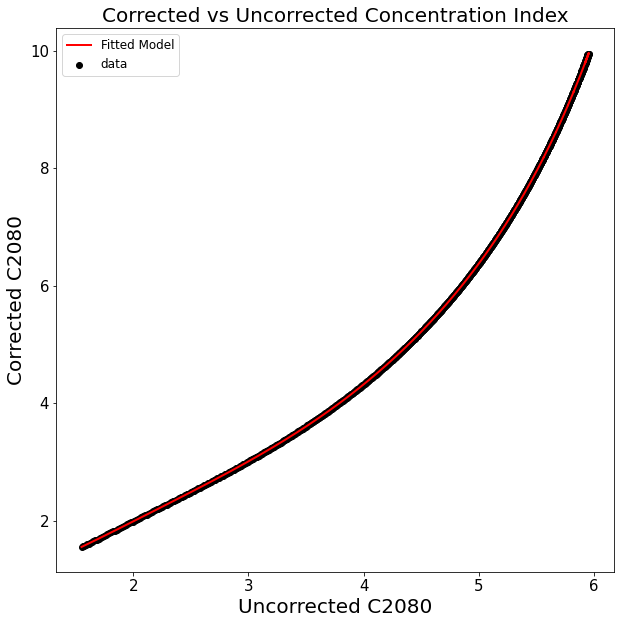

In [107]:
max_n = 15

x = list(t[np.where(t['sersic_n'] < max_n)]['uncorr_c2080']) 
y = list(t[np.where(t['sersic_n'] < max_n)]['corr_c2080'])

x = np.array(x)
y = np.array(y)

plt.scatter(x, y, marker='o', c='black', label='data')

# initialize a linear fitter
fit = fitting.LevMarLSQFitter()
fit = fitting.LinearLSQFitter()

# initialize a linear model
exp1d = models.Exponential1D()
power = powerlaws.SmoothlyBrokenPowerLaw1D()

line_init =  models.Polynomial1D(6)

fitted_line = fit(line_init, x, y)

c_relation = fitted_line

print(fitted_line.param_names)
print(fitted_line.parameters)

arr = np.arange(min(x), max(x)+0.1, 0.1)

plt.plot(x, fitted_line(x), c='red', linewidth=2,
         label='Fitted Model'.format(*fitted_line.parameters))

plt.title("Corrected vs Uncorrected Concentration Index")
plt.xlabel("Uncorrected C2080")
plt.ylabel("Corrected C2080")
plt.legend()

savefig("corr_vs_uncorr_c2080.png")

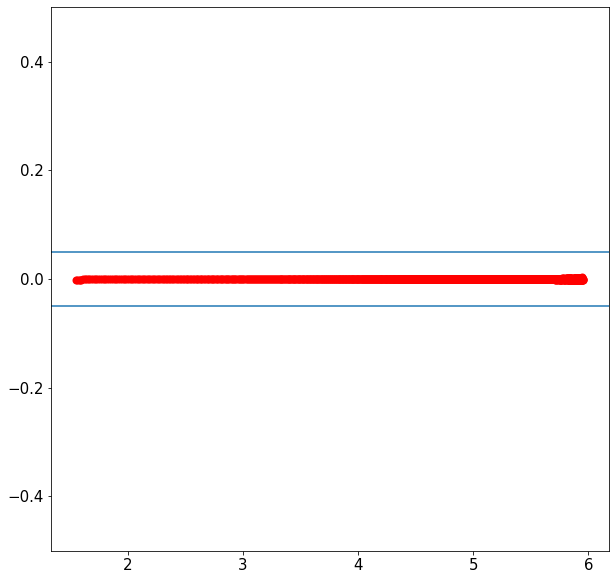

In [108]:
plt.scatter(x, (y-fitted_line(x))/y, c='red', linewidth=2,
         label='Fitted Model'.format(*fitted_line.parameters))

plt.ylim(-.5, .5)
plt.axhline(-.05)
plt.axhline(.05)
plt.show()

In [109]:
print(repr(c_relation))

<Polynomial1D(6, c0=1.77856622, c1=-2.76975575, c2=3.23208912, c3=-1.42780104, c4=0.33829858, c5=-0.04068859, c6=0.0020372)>


## Concentration Index vs Sérsic Index

('c0', 'c1', 'c2', 'c3', 'c4', 'c5')
[-5.08748925e-01  2.94552528e-01  5.31459162e-02  1.64253023e-02
 -1.30030606e-03  3.98915354e-05]


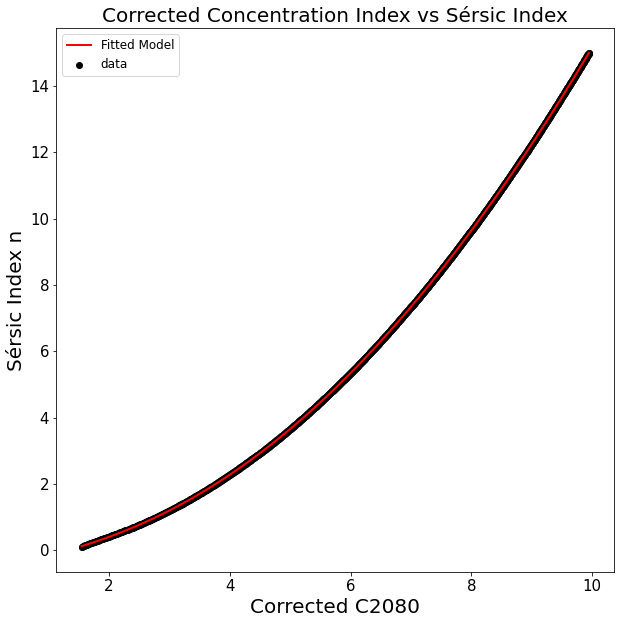

In [110]:
max_n = 15
x = list(t[np.where(t['sersic_n'] < max_n)]['corr_c2080']) 
y = list(t[np.where(t['sersic_n'] < max_n)]['sersic_n'])

x = np.array(x)
y = np.array(y)

plt.scatter(x, y, marker='o', c='black', label='data')

# initialize a linear fitter
fit = fitting.LevMarLSQFitter()
fit = fitting.LinearLSQFitter()

# initialize a linear model
exp1d = models.Exponential1D()
power = powerlaws.PowerLaw1D()

line_init =  models.Polynomial1D(5)

fitted_line = fit(line_init, x, y)#, maxiter=100000, acc=0)

print(fitted_line.param_names)
print(fitted_line.parameters)

arr = np.arange(min(x), max(x), 0.1)

plt.plot(x, fitted_line(x), c='red', linewidth=2,
         label='Fitted Model'.format(*fitted_line.parameters))

plt.title("Corrected Concentration Index vs Sérsic Index")
plt.xlabel("Corrected C2080")
plt.ylabel("Sérsic Index n")
plt.legend()

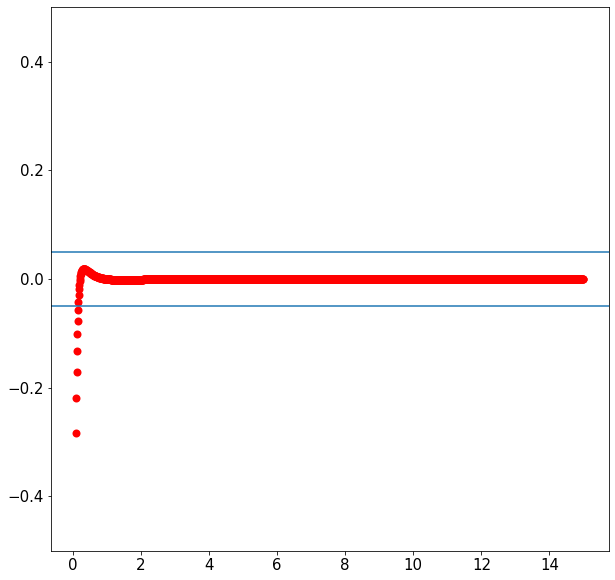

In [111]:

plt.scatter(y, (y-fitted_line(x))/y, c='red', linewidth=2,
         label='Fitted Model'.format(*fitted_line.parameters))

plt.ylim(-.5, .5)
plt.axhline(-.05)
plt.axhline(.05)
plt.show()

In [112]:
print(repr(fitted_line))
c2080_to_n = fitted_line

<Polynomial1D(5, c0=-0.50874892, c1=0.29455253, c2=0.05314592, c3=0.0164253, c4=-0.00130031, c5=0.00003989)>


## Epsilon vs Sérsic Index

<CompoundModel(c0_0=-6.57601462, c1_0=-2.16619122, c2_0=-0.28863463, c3_0=-0.04188336, c4_0=-0.00040084, c5_0=-0.00022806, amplitude_1=7.51854433, tau_1=2.68876053)>
[-6.57601462e+00 -2.16619122e+00 -2.88634626e-01 -4.18833596e-02
 -4.00840982e-04 -2.28061496e-04  7.51854433e+00  2.68876053e+00]


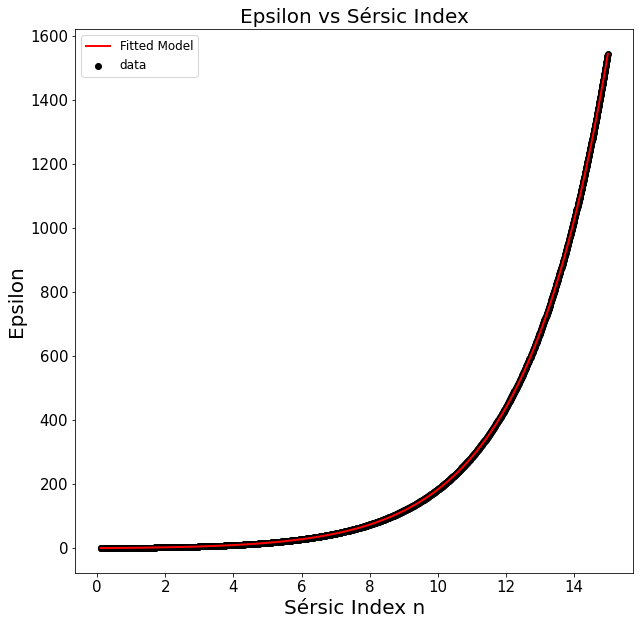

In [113]:
max_n = 15

x = list(t[np.where(t['sersic_n'] < max_n)]['sersic_n']) 
y = list(t[np.where(t['sersic_n'] < max_n)]['corr_epsilon'])

x = np.array(x)
y = np.array(y)

plt.scatter(x, y, marker='o', c='black', label='data')

# initialize a linear fitter
fit = fitting.LevMarLSQFitter()
#fit = fitting.LinearLSQFitter()

# initialize a linear model
exp1d = models.Exponential1D()
power = powerlaws.BrokenPowerLaw1D()

line_init = models.Polynomial1D(5) + exp1d 
fitted_line = fit(line_init, x, y, maxiter=10000, acc=0)

# x = list(t[np.where(t['sersic_n'] > 15)]['sersic_n']) 
# y = list(t[np.where(t['sersic_n'] > 15)]['corr_epsilon'])

# x = np.array(x)
# y = np.array(y)


print(repr(fitted_line))
print(fitted_line.parameters)

arr = np.array(list(np.arange(min(x), max(x), 0.1))+[max(x)])

plt.plot(x, fitted_line(x), c='red', linewidth=2,
         label='Fitted Model'.format(*fitted_line.parameters))

# plt.scatter(x, y, marker='o', c='b', label='data')

# plt.plot(x, models.Polynomial1D(4, c0=-5.09265992, c1=-1.5511942, c2=-0.28384006, c3=-0.00909155, c4=-0.00285897,)(x))
# plt.plot(x, models.Exponential1D(6.00314167, tau=2.62515105)(x))

plt.title("Epsilon vs Sérsic Index")
plt.xlabel("Sérsic Index n")
plt.ylabel("Epsilon")
plt.legend()


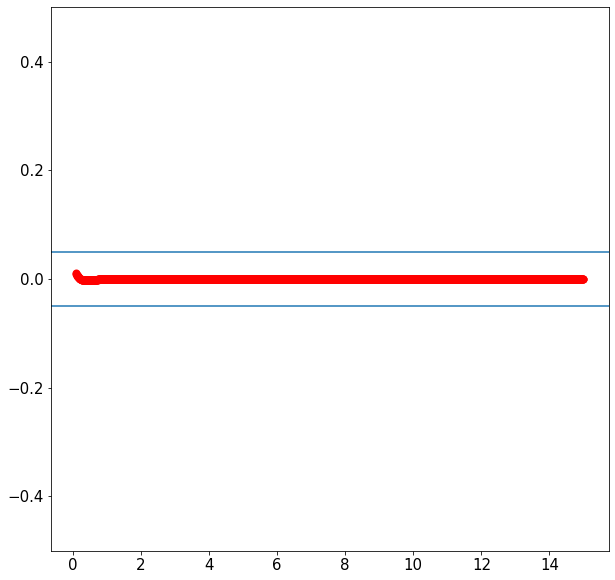

In [114]:

plt.scatter(x, (y-fitted_line(x))/y, c='red', linewidth=2,
         label='Fitted Model'.format(*fitted_line.parameters))

plt.ylim(-.5, .5)
plt.axhline(-.05)
plt.axhline(.05)
plt.show()

In [13]:
print(repr(fitted_line))
n_to_epsilon = fitted_line

<CompoundModel(c0_0=-6.54870813, c1_0=-2.15040843, c2_0=-0.28993623, c3_0=-0.04099376, c4_0=-0.00046837, c5_0=-0.00022305, amplitude_1=7.48787292, tau_1=2.6876055)>


<CompoundModel(amplitude_0=0.00092312, tau_0=0.70698771, c0_1=5.34492917, c1_1=-8.22486916, c2_1=6.04374925, c3_1=-2.22990781, c4_1=0.46613945, c5_1=-0.05115916, c6_1=0.00253108)>
[ 9.23123543e-04  7.06987710e-01  5.34492917e+00 -8.22486916e+00
  6.04374925e+00 -2.22990781e+00  4.66139452e-01 -5.11591609e-02
  2.53108097e-03]


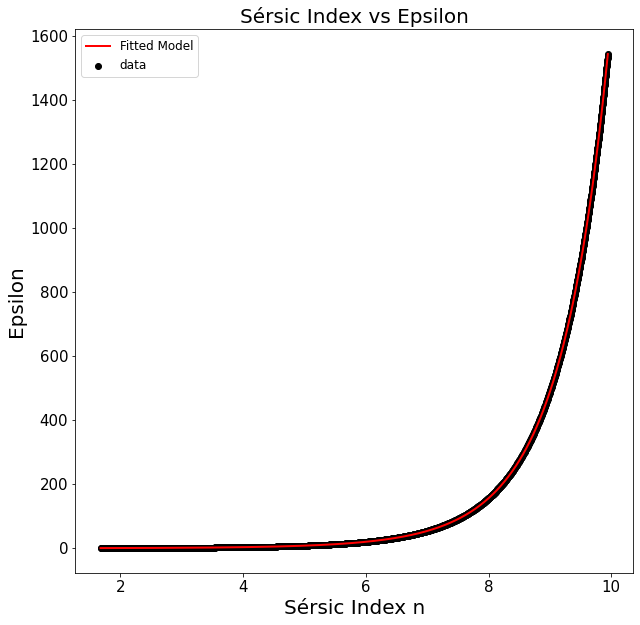

In [122]:
max_n = 15

x = list(t[np.where(t['sersic_n'] < max_n)]['corr_c2080']) 
y = list(t[np.where(t['sersic_n'] < max_n)]['corr_epsilon'])

x = np.array(x)
y = np.array(y)

#x = np.log10((np.exp(x/5))**-1)*5

plt.scatter(x, y, marker='o', c='black', label='data')

# initialize a linear fitter
fit = fitting.LevMarLSQFitter()
#fit = fitting.LinearLSQFitter()

# initialize a linear model
exp1d = models.Exponential1D(tau=1)
power = powerlaws.BrokenPowerLaw1D()

line_init =  exp1d + models.Polynomial1D(6)
fitted_line = fit(line_init, x, y, maxiter=1000000, acc=0)

# x = list(t[np.where(t['sersic_n'] > 15)]['sersic_n']) 
# y = list(t[np.where(t['sersic_n'] > 15)]['corr_epsilon'])

# x = np.array(x)
# y = np.array(y)


print(repr(fitted_line))
print(fitted_line.parameters)

arr = np.array(list(np.arange(min(x), max(x), 0.1))+[max(x)])

plt.plot(x, fitted_line(x), c='red', linewidth=2,
         label='Fitted Model'.format(*fitted_line.parameters))

# plt.scatter(x, y, marker='o', c='b', label='data')

# plt.plot(x, models.Polynomial1D(4, c0=-5.09265992, c1=-1.5511942, c2=-0.28384006, c3=-0.00909155, c4=-0.00285897,)(x))
# plt.plot(x, models.Exponential1D(6.00314167, tau=2.62515105)(x))

plt.title("Sérsic Index vs Epsilon")
plt.xlabel("Sérsic Index n")
plt.ylabel("Epsilon")
plt.legend()


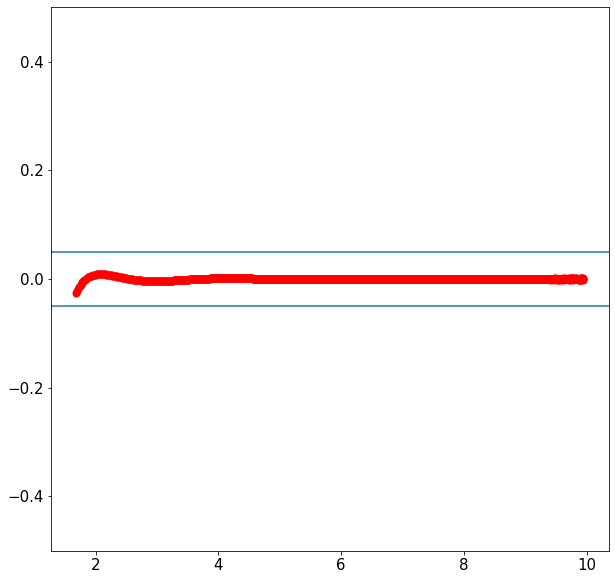

In [123]:

plt.scatter(x, (y-fitted_line(x))/y, c='red', linewidth=2,
         label='Fitted Model'.format(*fitted_line.parameters))

plt.ylim(-.5, .5)
plt.axhline(-.05)
plt.axhline(.05)
plt.show()

## corr_epsilon vs  sersic_petro_0502

<CompoundModel(c0_0=1.03102848, c1_0=-0.05419189, c2_0=0.45187698, c3_0=-0.10857379, c4_0=0.02359318, c5_0=-0.00184624, c6_0=0.00008735, amplitude_1=0.03766698, tau_1=1.85408713)>
[ 1.03102848e+00 -5.41918938e-02  4.51876984e-01 -1.08573785e-01
  2.35931815e-02 -1.84624451e-03  8.73478102e-05  3.76669777e-02
  1.85408713e+00]


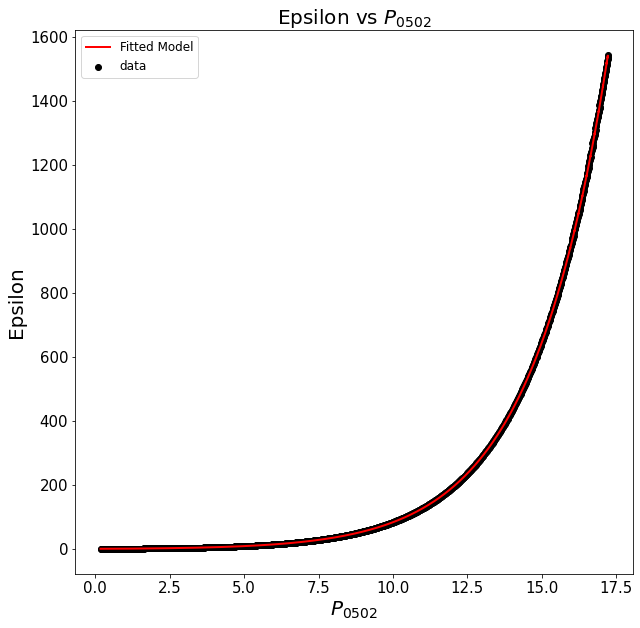

In [130]:
max_n = 15

x = list(t[np.where(t['sersic_n'] < max_n)]['sersic_petro_0502']) 
y = list(t[np.where(t['sersic_n'] < max_n)]['corr_epsilon'])

x = np.array(x)
y = np.array(y)

#x = np.log10((np.exp(x/5))**-1)*5

plt.scatter(x, y, marker='o', c='black', label='data')

# initialize a linear fitter
fit = fitting.LevMarLSQFitter()
#fit = fitting.LinearLSQFitter()

# initialize a linear model
exp1d = models.Exponential1D()
power = powerlaws.BrokenPowerLaw1D()

line_init =    models.Polynomial1D(6) + exp1d
fitted_line = fit(line_init, x, y, maxiter=1000000, acc=0)

# x = list(t[np.where(t['sersic_n'] > 15)]['sersic_n']) 
# y = list(t[np.where(t['sersic_n'] > 15)]['corr_epsilon'])

# x = np.array(x)
# y = np.array(y)


print(repr(fitted_line))
print(fitted_line.parameters)

arr = np.array(list(np.arange(min(x), max(x), 0.1))+[max(x)])

plt.plot(x, fitted_line(x), c='red', linewidth=2,
         label='Fitted Model'.format(*fitted_line.parameters))

# plt.scatter(x, y, marker='o', c='b', label='data')

# plt.plot(x, models.Polynomial1D(4, c0=-5.09265992, c1=-1.5511942, c2=-0.28384006, c3=-0.00909155, c4=-0.00285897,)(x))
# plt.plot(x, models.Exponential1D(6.00314167, tau=2.62515105)(x))

plt.title("Epsilon vs $P_{0502}$")
plt.xlabel("$P_{0502}$")
plt.ylabel("Epsilon")
plt.legend()


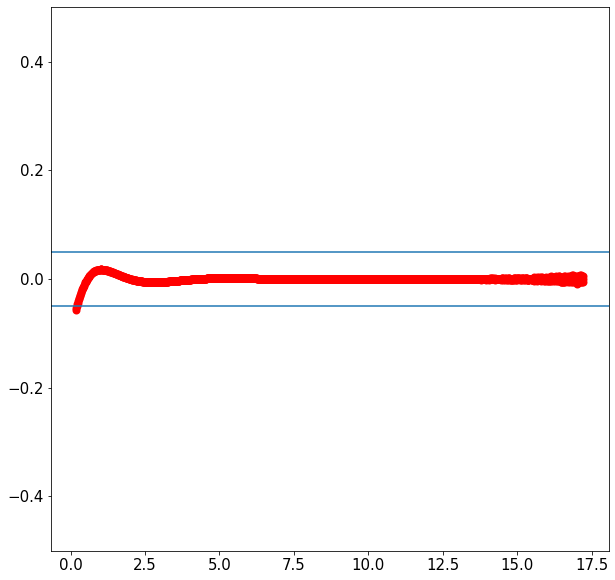

In [131]:

plt.scatter(x, (y-fitted_line(x))/y, c='red', linewidth=2,
         label='Fitted Model'.format(*fitted_line.parameters))

plt.ylim(-.5, .5)
plt.axhline(-.05)
plt.axhline(.05)
plt.show()

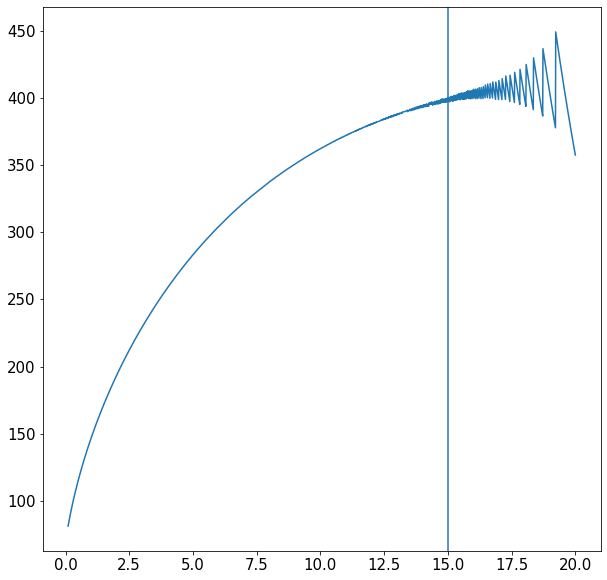

In [132]:
plt.plot(t['sersic_n'], np.exp(t['sersic_petro_0502']/5)*t['corr_r_petrosian'])
plt.axvline(15)

# Missing Mag

In [118]:
@custom_model
def missing_mag(x, p1=5.1e-4, p2=1.451, c=0):
    return p1*np.exp(x**p2) + c

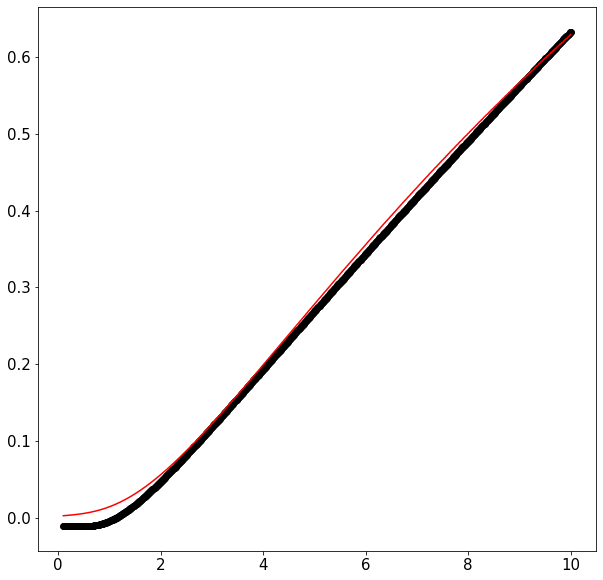

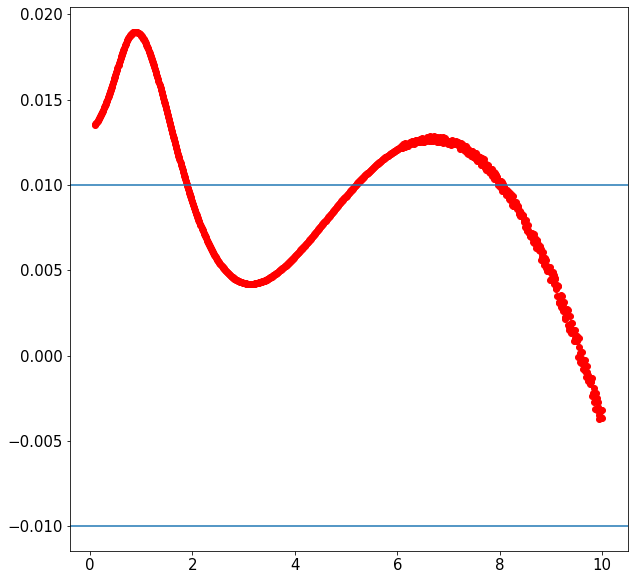

In [134]:
max_n = 10
idxs = np.where(t['sersic_n'] <=max_n)

x = t['uncorr_r_90'][idxs] / t['uncorr_r_50'][idxs]
y = (-2.5*np.log10(t['uncorr_total_flux'][idxs])) - (-2.5*np.log10(t['corr_total_flux'][idxs]))
z = missing_mag()(x)
n = t['sersic_n'][idxs]

plt.scatter(n, y, c='black')
plt.plot(n, z, c='r')
plt.show()

plt.scatter(n, (z-y), c='r')

plt.axhline(0.01)
plt.axhline(-0.01)


plt.show()

###################################################



Model: CompoundModel
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1]
Components: 
    [0]: <Exponential1D(amplitude=0., tau=0.18417281)>

    [1]: <Polynomial1D(3, c0=-0.35408494, c1=0.54083087, c2=-0.28336054, c3=0.04970694)>
Parameters:
         amplitude_0              tau_0        ...         c3_1       
    ---------------------- ------------------- ... -------------------
    1.9677000455852022e-10 0.18417281237521013 ... 0.04970694278577313
 
<CompoundModel(amplitude_0=0., tau_0=0.18417281, c0_1=-0.35408494, c1_1=0.54083087, c2_1=-0.28336054, c3_1=0.04970694)>


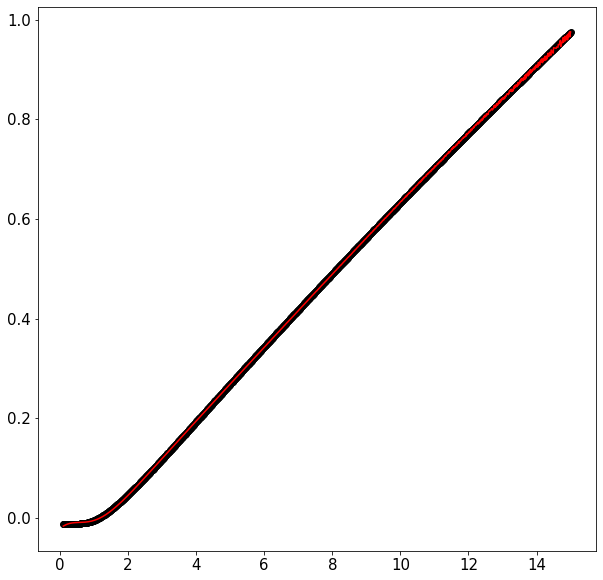

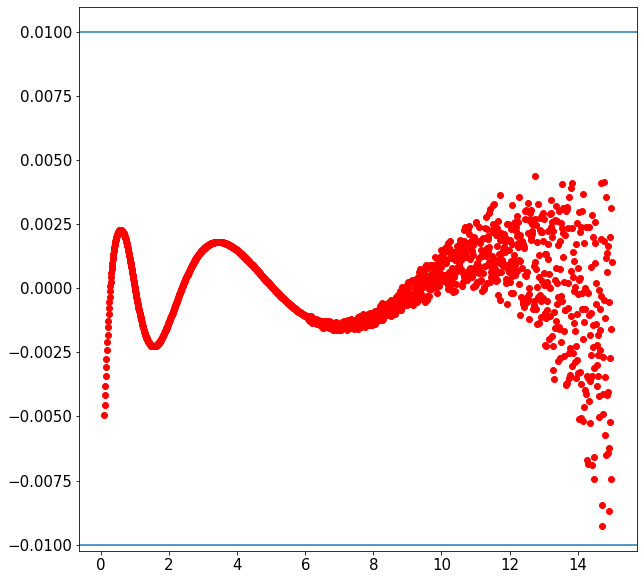

In [120]:
x = t['uncorr_r_90'][idxs] / t['uncorr_r_50'][idxs]

line_init = missing_mag()
line_init = models.Exponential1D(amplitude=3) + models.Polynomial1D(3)

fit = fitting.LevMarLSQFitter()
fitted_line = fit(line_init, x, y, maxiter=100000, acc=1e-07,)
print(fitted_line)

plt.scatter(n, y, c='black')
plt.plot(n, fitted_line(x), c='r')

print(" ")
print(repr(fitted_line))

plt.show()

plt.scatter(n, (fitted_line(x)-y), c='r')

plt.axhline(0.01)
plt.axhline(-0.01)


plt.show()

Model: CompoundModel
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1]
Components: 
    [0]: <Exponential1D(amplitude=7.99198899, tau=13.24300281)>

    [1]: <Polynomial1D(3, c0=-7.9366165, c1=-0.66002936, c2=-0.00966473, c3=-0.00115416)>
Parameters:
       amplitude_0          tau_0       ...          c3_1         
    ----------------- ----------------- ... ----------------------
    7.991988989565522 13.24300280598807 ... -0.0011541642585748623
 
<CompoundModel(amplitude_0=7.99198899, tau_0=13.24300281, c0_1=-7.9366165, c1_1=-0.66002936, c2_1=-0.00966473, c3_1=-0.00115416)>


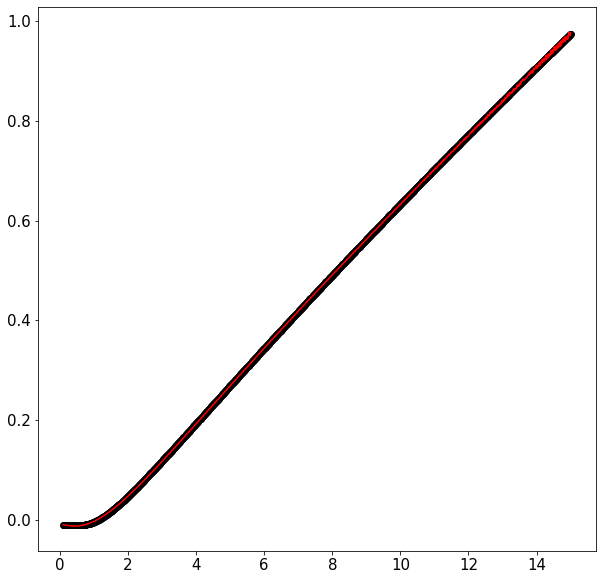

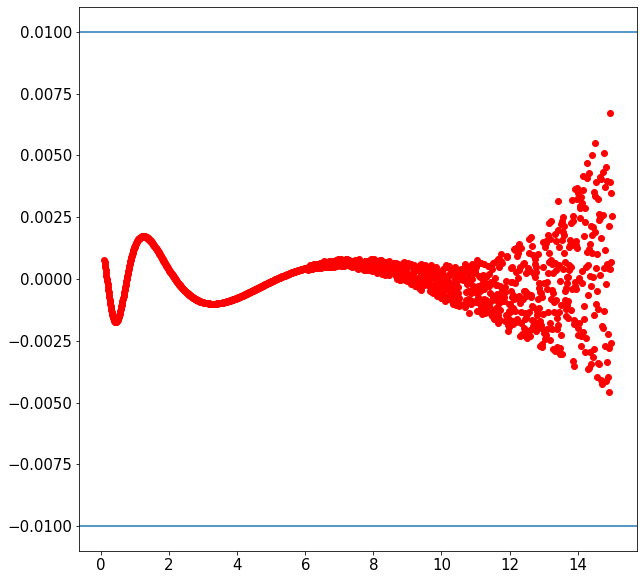

In [122]:
x = t['uncorr_r_80'][idxs] / t['uncorr_r_20'][idxs]

line_init = missing_mag()
line_init = models.Exponential1D() + models.Polynomial1D(3)

fit = fitting.LevMarLSQFitter()
fitted_line = fit(line_init, x, y, maxiter=10000, acc=1e-07,)
print(fitted_line)

plt.scatter(n, y, c='black')
plt.plot(n, fitted_line(x), c='r')

print(" ")
print(repr(fitted_line))
plt.show()

plt.scatter(n, (fitted_line(x)-y), c='r')

plt.axhline(0.01)
plt.axhline(-0.01)


plt.show()

Model: CompoundModel
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1]
Components: 
    [0]: <Exponential1D(amplitude=0.00000324, tau=0.51992048)>

    [1]: <Polynomial1D(3, c0=-0.04990413, c1=0.07810246, c2=-0.04810471, c3=0.00929017)>
Parameters:
         amplitude_0             tau_0        ...         c3_1        
    ---------------------- ------------------ ... --------------------
    3.2414167355270157e-06 0.5199204814725538 ... 0.009290169185498033
 
<CompoundModel(amplitude_0=0.00000324, tau_0=0.51992048, c0_1=-0.04990413, c1_1=0.07810246, c2_1=-0.04810471, c3_1=0.00929017)>


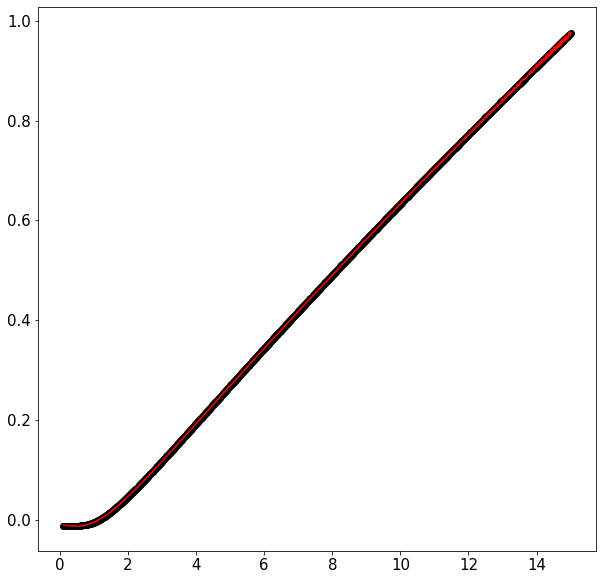

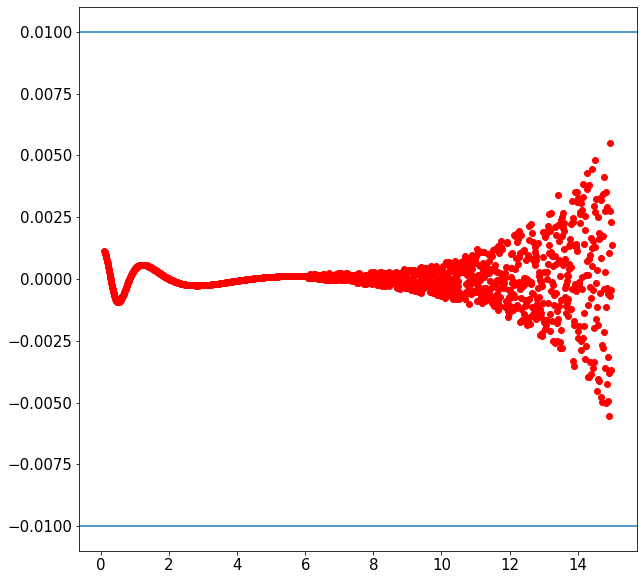

In [123]:
x = t['uncorr_c2080'][idxs]

line_init = missing_mag()
line_init = models.Exponential1D(1) + models.Polynomial1D(3)

fit = fitting.LevMarLSQFitter()
fitted_line = fit(line_init, x, y, maxiter=10000, acc=1e-07,)
print(fitted_line)

plt.scatter(n, y, c='black')
plt.plot(n, fitted_line(x), c='r')

print(" ")
print(repr(fitted_line))
plt.show()

plt.scatter(n, (fitted_line(x)-y), c='r')

plt.axhline(0.01)
plt.axhline(-0.01)


plt.show()

# Plots

('c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6')
[ 2.26194802e+00 -3.61130833e+00  3.82197580e+00 -1.64146601e+00
  3.80594089e-01 -4.50384010e-02  2.21921665e-03]


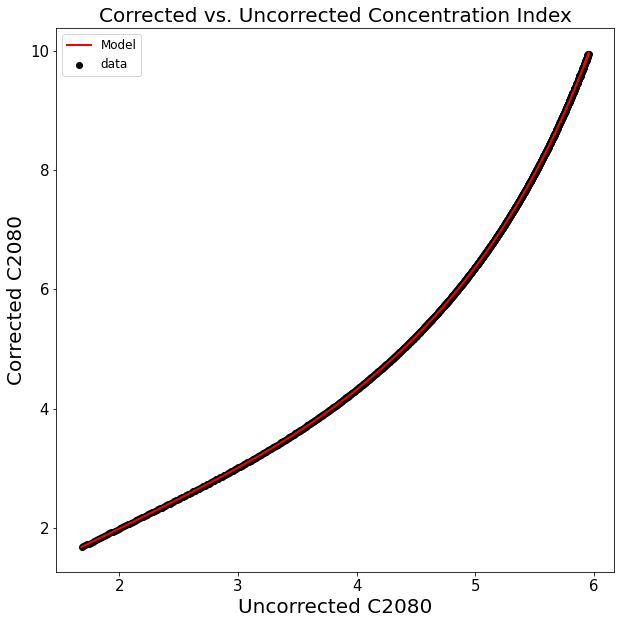

In [37]:
x = list(t[np.where(t['sersic_n'] < 15)]['uncorr_c2080']) 
y = list(t[np.where(t['sersic_n'] < 15)]['corr_c2080'])

x = np.array(x)
y = np.array(y)

plt.scatter(x, y, marker='o', c='black', label='data')

fitted_line = c_relation 

print(fitted_line.param_names)
print(fitted_line.parameters)

arr = np.arange(min(x), max(x)+0.1, 0.1)

plt.plot(x, fitted_line(x), c='red', linewidth=2,
         label='Model'.format(*fitted_line.parameters))

plt.title("Corrected vs. Uncorrected Concentration Index")
plt.xlabel("Uncorrected C2080")
plt.ylabel("Corrected C2080")
plt.legend()

savefig("corr_vs_uncorr_c2080.png")

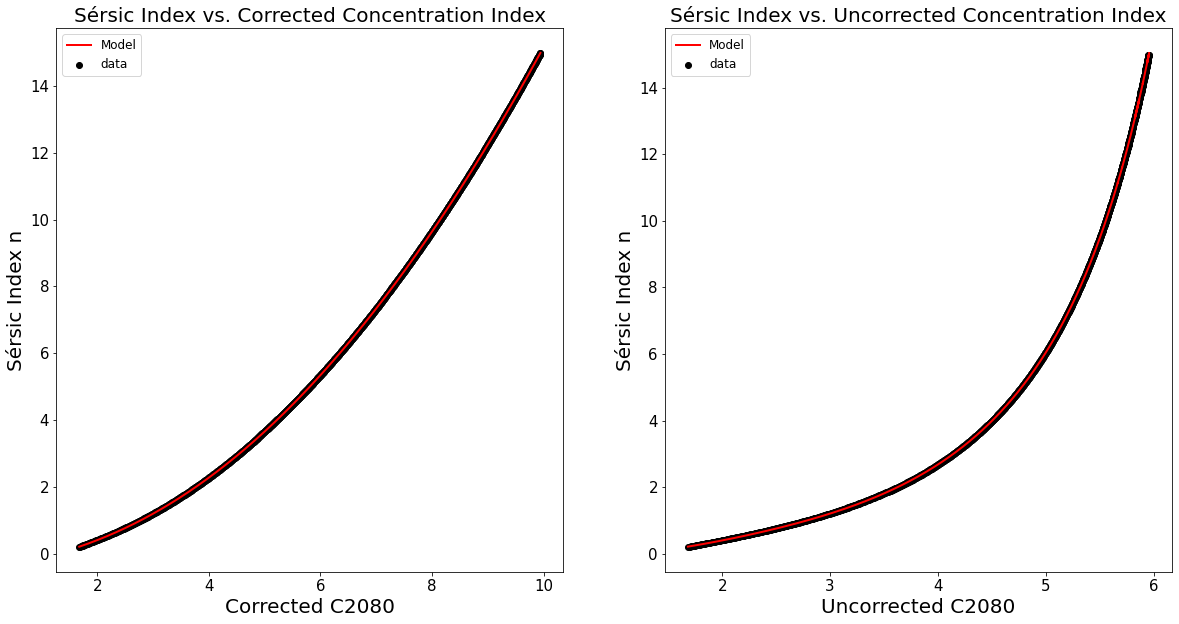

In [38]:
figsize = [10*2., 10*1]
fig, ax = plt.subplots(1, 2, figsize=figsize)

plt.sca(ax[0])

max_n = 15
x = list(t[np.where(t['sersic_n'] < max_n)]['corr_c2080']) 
y = list(t[np.where(t['sersic_n'] < max_n)]['sersic_n'])

x = np.array(x)
y = np.array(y)

plt.scatter(x, y, marker='o', c='black', label='data')

fitted_line = c2080_to_n


plt.plot(x, fitted_line(x), c='red', linewidth=2,
         label='Model')

plt.title("Sérsic Index vs. Corrected Concentration Index")
plt.xlabel("Corrected C2080")
plt.ylabel("Sérsic Index n")
plt.legend()

###########################################################

plt.sca(ax[1])

x = list(t[np.where(t['sersic_n'] < 15)]['uncorr_c2080']) 
y = list(t[np.where(t['sersic_n'] < 15)]['sersic_n'])

x = np.array(x)
y = np.array(y)

plt.scatter(x, y, marker='o', c='black', label='data')

fitted_line = lambda x: c2080_to_n(c_relation(x))


plt.plot(x, fitted_line(x), c='red', linewidth=2,
         label='Model')

plt.title("Sérsic Index vs. Uncorrected Concentration Index")
plt.xlabel("Uncorrected C2080")
plt.ylabel("Sérsic Index n")
plt.legend()


savefig("c2080_vs_n.png")

corr_c2080
uncorr_c2080
sersic_n
('c0_0', 'c1_0', 'c2_0', 'c3_0', 'c4_0', 'c5_0', 'amplitude_1', 'tau_1')
[-6.54870813e+00 -2.15040843e+00 -2.89936225e-01 -4.09937602e-02
 -4.68370934e-04 -2.23047997e-04  7.48787292e+00  2.68760550e+00]


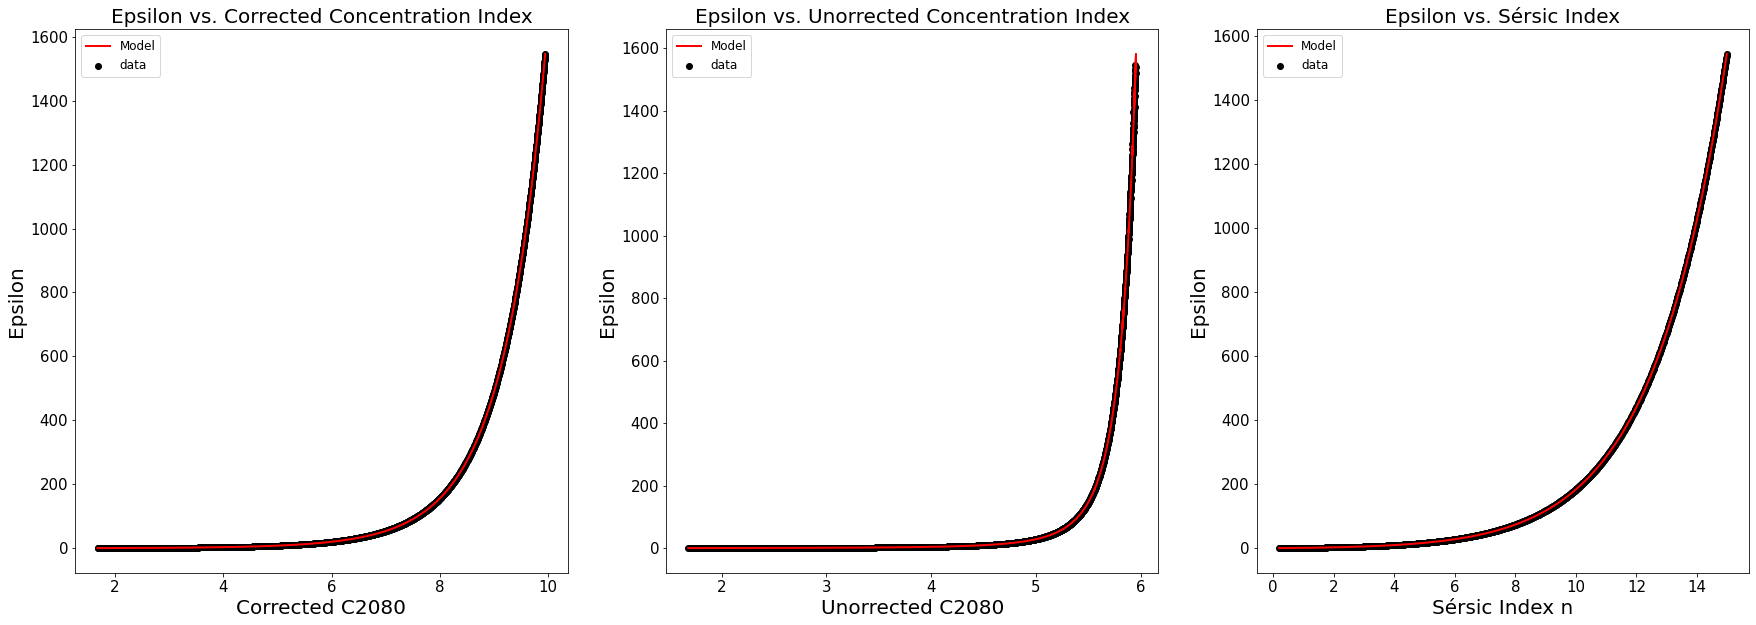

In [40]:
max_n = 15

figsize = [10*3., 10*1]
fig, ax = plt.subplots(1, 3, figsize=figsize)

plt.sca(ax[0])


print('corr_c2080')
x = list(t[np.where(t['sersic_n'] < max_n)]['corr_c2080']) 
y = list(t[np.where(t['sersic_n'] < max_n)]['corr_epsilon'])

x = np.array(x)
y = np.array(y)

plt.scatter(x, y, marker='o', c='black', label='data')

fitted_line = lambda x: n_to_epsilon(c2080_to_n(x))

plt.plot(x, fitted_line(x), c='red', linewidth=2,
         label='Model')

plt.title("Epsilon vs. Corrected Concentration Index")
plt.xlabel("Corrected C2080")
plt.ylabel("Epsilon")
plt.legend()

###########################################################

plt.sca(ax[1])
print('uncorr_c2080')
x = list(t[np.where(t['sersic_n'] < max_n)]['uncorr_c2080']) 
y = list(t[np.where(t['sersic_n'] < max_n)]['corr_epsilon'])

x = np.array(x)
y = np.array(y)

plt.scatter(x, y, marker='o', c='black', label='data')

fitted_line = lambda x: n_to_epsilon(c2080_to_n(c_relation(x)))

plt.plot(x, fitted_line(x), c='red', linewidth=2,
         label='Model')

plt.title("Epsilon vs. Unorrected Concentration Index")
plt.xlabel("Unorrected C2080")
plt.ylabel("Epsilon")
plt.legend()


###########################################################

plt.sca(ax[2])
print('sersic_n')
x = list(t[np.where(t['sersic_n'] < max_n)]['sersic_n']) 
y = list(t[np.where(t['sersic_n'] < max_n)]['corr_epsilon'])

x = np.array(x)
y = np.array(y)

plt.scatter(x, y, marker='o', c='black', label='data')

fitted_line = n_to_epsilon

print(fitted_line.param_names)
print(fitted_line.parameters)

arr = np.array(list(np.arange(min(x), max(x), 0.1))+[max(x)])

plt.plot(x, fitted_line(x), c='red', linewidth=2,
         label='Model'.format(*fitted_line.parameters))

plt.title("Epsilon vs. Sérsic Index")
plt.xlabel("Sérsic Index n")
plt.ylabel("Epsilon")
plt.legend()

savefig("epsilon_vs_n_and_c2080.png")
plt.show()


<CompoundModel(c0_0=1.09339575, c1_0=-0.14524927, c2_0=0.50361706, c3_0=-0.12158092, c4_0=0.02533796, c5_0=-0.00196243, c6_0=0.00009081, amplitude_1=0.03312881, tau_1=1.83616642)>
[ 1.09339575e+00 -1.45249265e-01  5.03617061e-01 -1.21580925e-01
  2.53379565e-02 -1.96242982e-03  9.08056508e-05  3.31288109e-02
  1.83616642e+00]


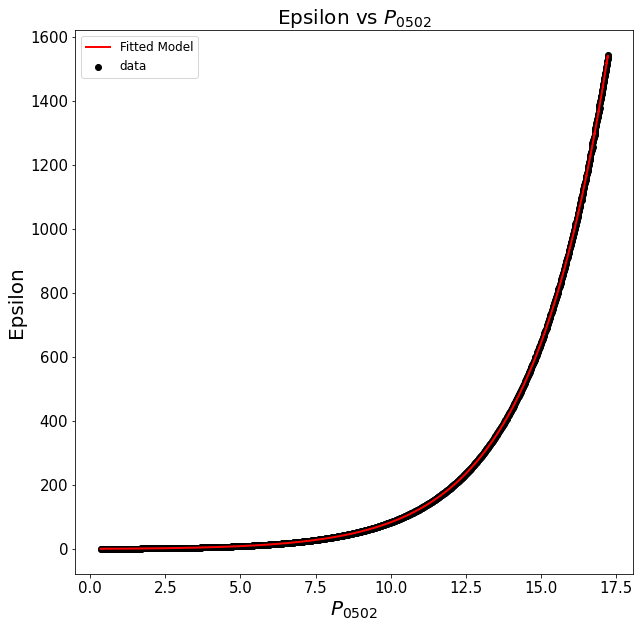

In [141]:
max_n = 15

x = list(t[np.where(t['sersic_n'] < max_n)]['sersic_petro_0502']) 
y = list(t[np.where(t['sersic_n'] < max_n)]['corr_epsilon'])

x = np.array(x)
y = np.array(y)

#x = np.log10((np.exp(x/5))**-1)*5

plt.scatter(x, y, marker='o', c='black', label='data')

# initialize a linear fitter
fit = fitting.LevMarLSQFitter()
#fit = fitting.LinearLSQFitter()

# initialize a linear model
exp1d = models.Exponential1D()
power = powerlaws.BrokenPowerLaw1D()

line_init =    models.Polynomial1D(6) + exp1d
fitted_line = fit(line_init, x, y, maxiter=1000000, acc=0)

# x = list(t[np.where(t['sersic_n'] > 15)]['sersic_n']) 
# y = list(t[np.where(t['sersic_n'] > 15)]['corr_epsilon'])

# x = np.array(x)
# y = np.array(y)


print(repr(fitted_line))
print(fitted_line.parameters)

arr = np.array(list(np.arange(min(x), max(x), 0.1))+[max(x)])

plt.plot(x, fitted_line(x), c='red', linewidth=2,
         label='Fitted Model'.format(*fitted_line.parameters))

# plt.scatter(x, y, marker='o', c='b', label='data')

# plt.plot(x, models.Polynomial1D(4, c0=-5.09265992, c1=-1.5511942, c2=-0.28384006, c3=-0.00909155, c4=-0.00285897,)(x))
# plt.plot(x, models.Exponential1D(6.00314167, tau=2.62515105)(x))

plt.title("Epsilon vs $P_{0502}$")
plt.xlabel("$P_{0502}$")
plt.ylabel("Epsilon")
plt.legend()


savefig("epsilon_vs_P0502.png")
plt.show()

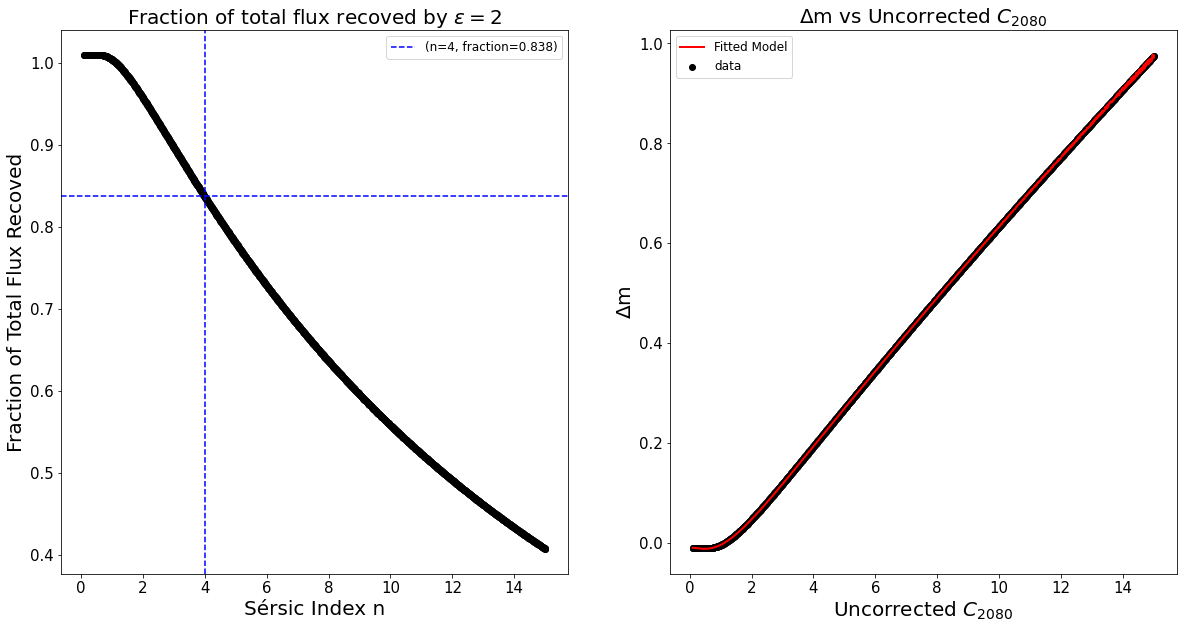

In [125]:
figsize = [10*2., 10*1]
fig, ax = plt.subplots(1, 2, figsize=figsize)

plt.sca(ax[0])

max_n = 15
idxs = np.where(t['sersic_n'] <=15)

plt.scatter(t['sersic_n'][idxs], t['uncorr_total_flux'][idxs]/t['corr_total_flux'][idxs], c='black')

plt.axvline(4, linestyle='--', label='(n=4, fraction=0.838)', c='b')
plt.axhline(0.838, linestyle='--', c='b')

plt.xlabel('Sérsic Index n')
plt.ylabel('Fraction of Total Flux Recoved')
plt.title('Fraction of total flux recoved by $\epsilon = 2$')
plt.legend()



plt.sca(ax[1])

max_n = 15
idxs = np.where(t['sersic_n'] <=15)

x = t['uncorr_c2080'][idxs]
y = (-2.5*np.log10(t['uncorr_total_flux'][idxs])) - (-2.5*np.log10(t['corr_total_flux'][idxs]))
z = missing_mag()(x)
n = t['sersic_n'][idxs]

line_init = missing_mag()
line_init = models.Exponential1D() + models.Polynomial1D(3)

fit = fitting.LevMarLSQFitter()
fitted_line = fit(line_init, x, y, maxiter=10000, acc=1e-07,)

plt.scatter(n, y, c='black', label='data')
plt.plot(n, fitted_line(x), c='r', linewidth=2, label='Fitted Model'.format(*fitted_line.parameters))


plt.title("$\Delta$m vs Uncorrected $C_{2080}$")
plt.xlabel("Uncorrected $C_{2080}$")
plt.ylabel("$\Delta$m")
plt.legend()


savefig("fraction_of_total_flux_recoved.png")

In [128]:
fitted_line

<CompoundModel(amplitude_0=0.00000324, tau_0=0.51992048, c0_1=-0.04990413, c1_1=0.07810246, c2_1=-0.04810471, c3_1=0.00929017)>

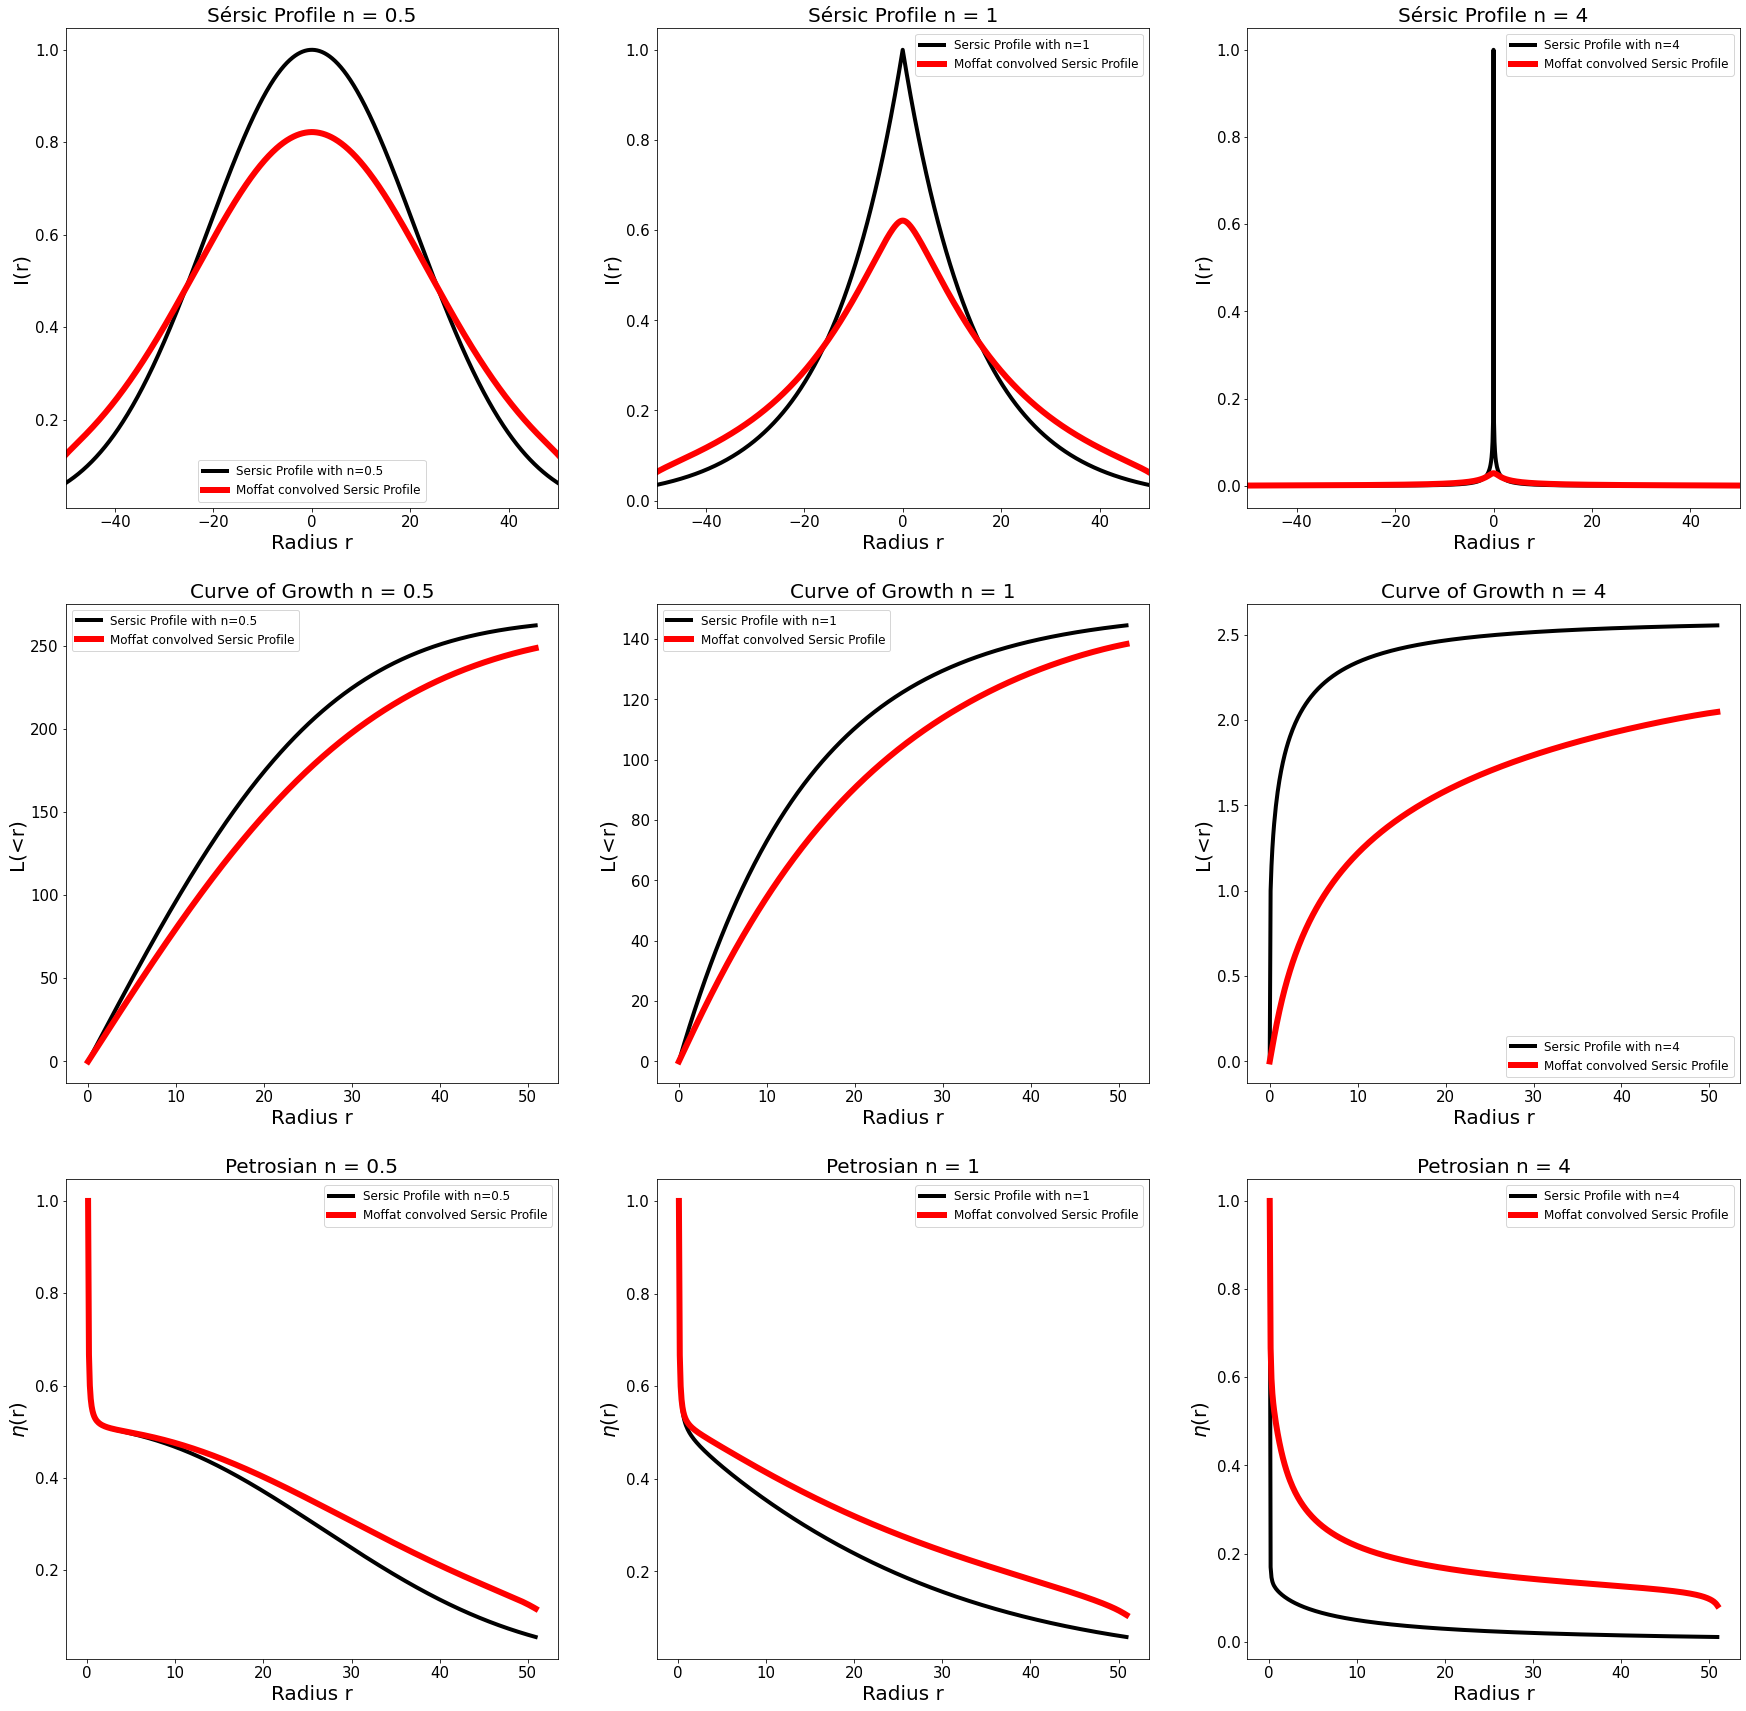

In [135]:
r_eff=25
figsize = [10*3., 10*3]
fig, ax = plt.subplots(3, 3, figsize=figsize)

r_list_half = np.arange(0, 51, 1)

r_list = list(-r_list_half) + list(r_list_half)
r_list = np.array(list(sorted(np.unique(np.array(r_list)))))


for i, n in enumerate([0.5, 1, 4]):
    plt.sca(ax[0, i])
    b_n = gammaincinv(2. * n, 0.5)
    amplitude=1 /np.exp(b_n)

    model = models.Sersic1D(amplitude, r_eff=r_eff, n=n)


    i_list =  model(abs(r_list))
    plt.plot(r_list, i_list, c='black', linewidth=4, label="Sersic Profile with n={}".format(n))
    #plt.fill_between(r_list, i_list, color='b', alpha=0.1)
    #plt.bar(r_list, i_list, alpha=0.3)
    
    psf = models.Moffat1D(amplitude=1, gamma=1, alpha=0.5)(r_list)
    psf = psf/psf.sum()
    con_list = convolve(i_list, psf)

    plt.plot(r_list, con_list, c='r', linewidth=6, label="Moffat convolved Sersic Profile".format(n))
    #plt.fill_between(r_list, con_list, color='r', alpha=0.3)
    #plt.bar(r_list, con_list, width=0.6, color='r', alpha=0.3)
    
    plt.xlim(-50,50)
    plt.title("Sérsic Profile n = {}".format(n))
    plt.xlabel("Radius r")
    plt.ylabel("I(r)")
    plt.legend()
    
    plt.sca(ax[1, i])
    half_idx = r_list_half.size-1
    
    f_list = [sum(i_list[half_idx: half_idx+i]) for i in range(half_idx+1)]
    f_con_list = [sum(con_list[half_idx: half_idx+i]) for i in range(half_idx+1)]
    
    plt.plot(r_list_half, f_list, c='black', linewidth=4, label="Sersic Profile with n={}".format(n))
    plt.plot(r_list_half, f_con_list, c='r', linewidth=6, label="Moffat convolved Sersic Profile".format(n))
    #plt.fill_between(r_list_half, f_con_list, color='r', alpha=0.3)
    
    plt.title("Curve of Growth n = {}".format(n))
    plt.xlabel("Radius r")
    plt.ylabel("L(<r)")
    plt.legend()
    
    plt.sca(ax[2, i])
    
    area = [np.pi*i**2 for i in range(half_idx+1)]
    
    p = calculate_petrosian(area, f_list)
    p_con = calculate_petrosian(area, f_con_list)
    
    plt.plot(r_list_half, p, c='black', linewidth=4, label="Sersic Profile with n={}".format(n))
    plt.plot(r_list_half, p_con, c='r', linewidth=6, label="Moffat convolved Sersic Profile".format(n))
    #plt.fill_between(r_list_half, p_con, color='r', alpha=0.3)
    
    plt.title("Petrosian n = {}".format(n))
    plt.xlabel("Radius r")
    plt.ylabel("$\eta$(r)")
    plt.legend()
    
    
    
    
savefig("psf_effect_sersic.png")

# Other

In [779]:
@custom_model
def f(c, k=2, a=1):
    return (c/k)**-a
    return amp*(lambertw(c*np.log10(k)) / np.log10(k)).astype(float)

('c0', 'c1', 'c2', 'c3')
[-0.30813975  0.06651458  0.14293203  0.00051809]


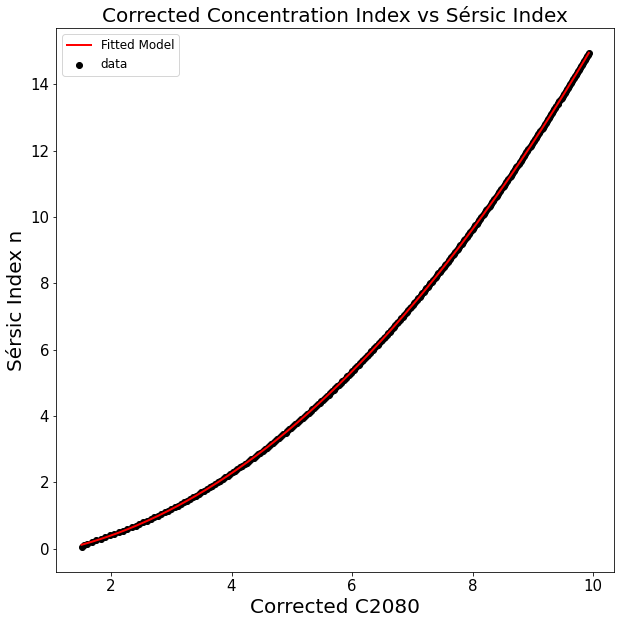

In [844]:
max_n = 15

x = list(t[np.where(t['sersic_n'] < max_n)]['corr_c2080']) 
y = list(t[np.where(t['sersic_n'] < max_n)]['sersic_n'])

x = np.array(x)
y = np.array(y)

plt.scatter(x, y, marker='o', c='black', label='data')

# initialize a linear fitter
fit = fitting.LevMarLSQFitter()
#fit = fitting.LinearLSQFitter()

# initialize a linear model
exp1d = models.Exponential1D()
power = powerlaws.BrokenPowerLaw1D() 

#line_init = power + models.Const1D()
#fitted_line = fit(line_init, x, y, maxiter=100000, acc=0)

print(fitted_line.param_names)
print(fitted_line.parameters)

arr = np.arange(min(x), max(x), 0.1)

plt.plot(x, fitted_line(x), c='red', linewidth=2,
         label='Fitted Model'.format(*fitted_line.parameters))

plt.title("Corrected Concentration Index vs Sérsic Index")
plt.xlabel("Corrected C2080")
plt.ylabel("Sérsic Index n")
plt.legend()